# Finance Exercise 

#### William Goode

### Introduction

This notebook analyzes a data set for The Acme Corporation, who sells widgets. In addition to selling widgets, Acme offers financing for the widgets. They have a test group and a control group, to whom they offer different APRs. Questions are written in code font at the start of each section except the Preliminary section. The questions involve trade-offs between various APRs, margins based on that APR, and whether or not a sale eventuates from the offered APR.

## Table of Contents
0. [Preliminary](#preliminary) 
1. [Acme Pricing](#acme_pricing)
2. [Customer Conversion Rate](#customer_conversion_rate)
3. [Acme Margin](#acme_margin)
4. [Margin Optimization](#margin_optimization)
5. [Summary Remarks](#summary_remarks)

### Preliminary <a class="anchor" id="preliminary"></a>

This initial section contains the necessary packages (both installation and import) should one want to run the notebook, as well as other set-up cells and some assignment information.

In [25]:
# %pip install catppuccin #color theme package
# %pip install nbconvert #notebook to pdf conversion package
# %pip install pandas
# %pip install matplotlib
# %pip install statsmodels
# %pip install seaborn

The below cell contains the figure size for bar graphs - alter as needed. The type is a `tuple` and the entries are (width, height) in inches.

In [26]:
size=(20,6)

All  packages for this document are contained below.

In [27]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns
import statsmodels

import catppuccin as cpn
from catppuccin import PALETTE

The following cell is just for aesthetics.

In [28]:
plt.rcParams["figure.figsize"] = size
mpl.style.use(["ggplot", cpn.PALETTE.mocha.identifier])
%config InteractiveShell.ast_node_interactivity = 'all'

And we load in the data here.

In [29]:
df = pd.read_csv('Finance_Analyst_Take_Home_Exercise_Data.csv')

To keep the document self-contained, we reproduce the data dictionary:

| Column                        | Description |
| --------                      | ------- |
| `app_id`                      | id # of the application    |
| `fico`                        | the FICO score of the applicant (700 or 600 in this exercise)|
| `apr_test_group`              | whether or not the applicant is in the test group (randomized)|
| `apr`                         | the APR that Acme offers the customer|
| `converted to sale`           | whether or not the applicant ended up buying a widget from Acme|
| `vehicle margin`              | the profit that Acme makes on selling the widget|
| `finance margin`              | the profit that Acme makes on the loan to the customer (after selling the loan to a counter-party at a fair price)|

We will also take a cursory look at the data.

In [30]:
df.head()
df.info()

,app_id,fico,apr_test_group,apr,converted to sale,vehicle margin,finance margin
0,1,700,control,4.00%,False,NaN,NaN
1,2,700,test,3.00%,False,NaN,NaN
2,3,700,test,3.00%,False,NaN,NaN
3,4,700,control,4.00%,False,NaN,NaN
4,5,700,control,4.00%,True,1000.0,600.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   app_id             20000 non-null  int64  
 1   fico               20000 non-null  int64  
 2   apr_test_group     20000 non-null  object 
 3   apr                20000 non-null  object 
 4   converted to sale  20000 non-null  bool   
 5   vehicle margin     5021 non-null   float64
 6   finance margin     5021 non-null   float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 957.2+ KB


### 1. Acme Pricing <a class="anchor" id="acme_pricing"></a>

`What’s the current APR pricing strategy for the different FICO buckets? How is the randomized test structured? How do APRs vary by test group?`

Let us first examine the possible column values. The following cell verifies there are 2 FICO buckets, 4 APR rates, and 2 test groups. Since all columns assume a small number of values, we will initially consider the data to be categorical and represent it in a contingency table.

In [31]:
print("FICO:", df['fico'].nunique(), df['fico'].unique())
print("APR:", df['apr'].nunique(), df['apr'].unique())
print("Test groups:", df['apr_test_group'].nunique(), df['apr_test_group'].unique())

FICO: 2 [700 600]
APR: 4 ['4.00%' '3.00%' '4.40%' '5.40%']
Test groups: 2 ['control' 'test']


In [32]:
pd.crosstab([df['fico'], df['apr_test_group']], df['apr']) 

apr                  3.00%  4.00%  4.40%  5.40%
fico apr_test_group                            
600  control             0      0      0   5095
     test                0      0   4906      0
700  control             0   4926      0      0
     test             5073      0      0      0

It is clear that a FICO of 600 means an APR of at least 4.40%, and a FICO of 700 means an APR of 4.00% or less. We can also see that the test group comprises a little over half of the data set. The table reveals that test group applicants had their APRs reduced by 1 point, regardless of their FICO. 

### 2. Customer Conversion Rate <a class="anchor" id="customer_conversion_rate"></a>

`In general, how many applications is Acme able to convert to a sale? How does that vary by FICO? Using the APR test group data, how does the APR affect conversion?`

In [33]:
print("Number of total applications converted to sale:", len(df[df['converted to sale']]))
print("Proportion of total applications converted to sale:", len(df[df['converted to sale']])/len(df))

Number of total applications converted to sale: 5021
Proportion of total applications converted to sale: 0.25105


5021 of the total 20,000 (approximately 25.11%) applications converted to a sale. The following table gives the distribution according to FICO category subdivided by APR (or equivalently, subdivided by test group).

In [34]:
sale_by_apr = pd.crosstab([df['fico'], df['apr']], df['converted to sale']) 
sale_by_apr = sale_by_apr.sort_index(level=0, ascending=False).sort_index(level=1, ascending=True)
sale_by_apr['total count'] = sale_by_apr[False] + sale_by_apr[True]
sale_by_apr

converted to sale  False  True  total count
fico apr                                   
700  3.00%          3568  1505         5073
     4.00%          3626  1300         4926
600  4.40%          3734  1172         4906
     5.40%          4051  1044         5095

This plain table is less informative than the conclusion of the first section, so we visualize it with two bar plots. The left bar plot is a side-by-side bar plot comparing the conversion frequency subdivided by APRs for all applicants. The right barplot shows the frequency of successful sale conversion by APR, without consideration of FICO. Note the difference in the scale of the y-axes.

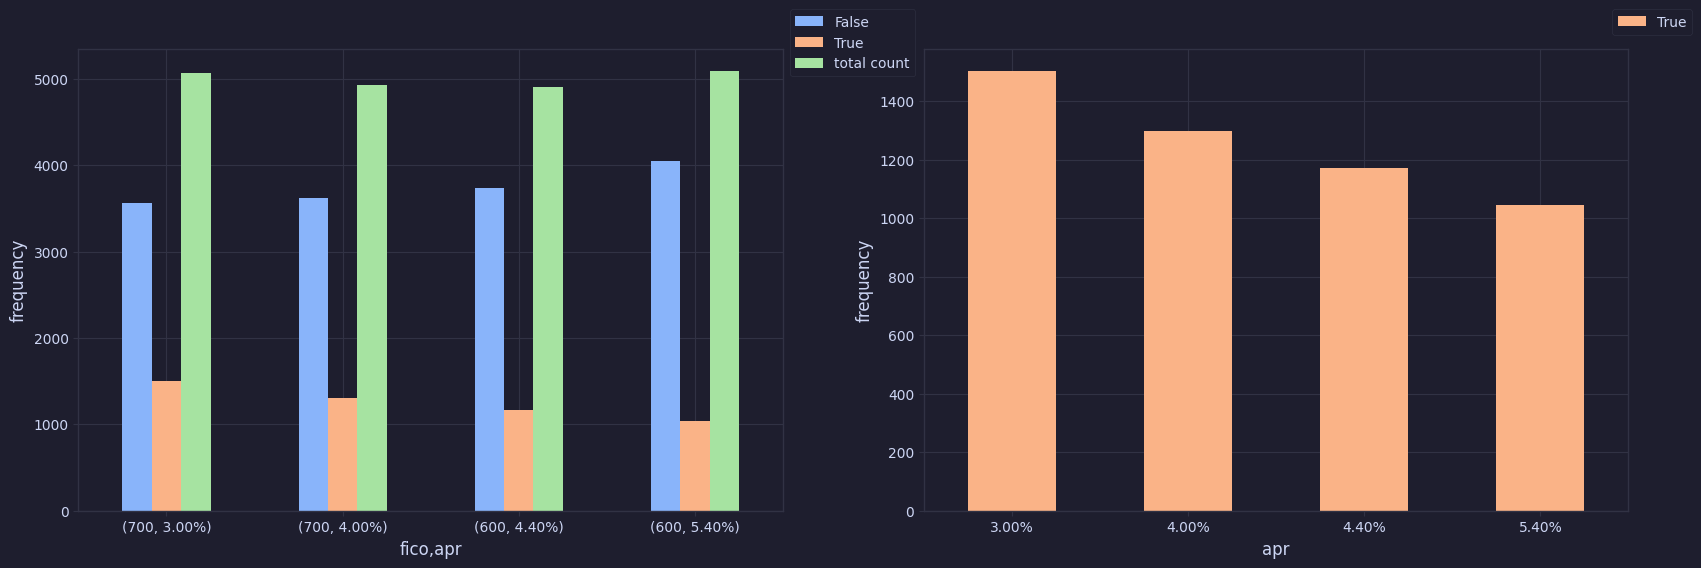

In [35]:
fig, ax = plt.subplots(1, 2, figsize=size)

sale_by_apr.plot.bar(rot=0, ax=ax[0]).set_ylabel('frequency')
ax[0].legend(bbox_to_anchor=(1, 1.1), fancybox=True);

sale_by_apr.droplevel(level='fico').sort_values('apr').drop(columns=[False, 'total count']).plot.bar(rot=0, ax=ax[1], color=PALETTE.mocha.colors.peach.hex).set_ylabel('frequency')
ax[1].legend(bbox_to_anchor=(1.1, 1.1), fancybox=True);

Clearly the test groups have higher conversion rates. To verify this is not due to chance, we perform a hypothesis test. The results are significant at the $\alpha = .01$ level.

In [36]:
from statsmodels.stats.proportion import proportions_ztest

true_700 = np.array([sale_by_apr[True].droplevel(level='fico').loc['3.00%'], sale_by_apr[True].droplevel(level='fico').loc['4.00%']])
total_700 = np.array([sale_by_apr['total count'].droplevel(level='fico').loc['3.00%'], sale_by_apr['total count'].droplevel(level='fico').loc['4.00%']])

true_600 = np.array([sale_by_apr[True].droplevel(level='fico').loc['4.40%'], sale_by_apr[True].droplevel(level='fico').loc['5.40%']])
total_600 = np.array([sale_by_apr['total count'].droplevel(level='fico').loc['5.40%'], sale_by_apr['total count'].droplevel(level='fico').loc['5.40%']])


test_stat_700, pval_700 = proportions_ztest(count = true_700, nobs = total_700, alternative='larger')
test_stat_600, pval_600 = proportions_ztest(count = true_600, nobs = total_600, alternative='larger')


test_stat_700, pval_700
test_stat_600, pval_600

(np.float64(3.6457568788037413), np.float64(0.0001333029720948497))

(np.float64(3.0737891124127876), np.float64(0.0010567939110436447))

The following table gives sale proportions. We have
\begin{align*} 
    \texttt{proportion of total sales} &= \frac{\text{number of sales in apr category}}{\text{total number of sales}} \\[1em]
    \texttt{apr category conversion rate} &= \frac{\text{number of sales in apr category}}{\text{total number of applicants in apr category}}
\end{align*}

In [37]:
sale_by_apr_relfreqs = (sale_by_apr[True]/len(df[df['converted to sale']])).to_frame()
sale_by_apr_relfreqs['apr category conversion rate'] = sale_by_apr[True]/(sale_by_apr[False]+sale_by_apr[True])
sale_by_apr_relfreqs = sale_by_apr_relfreqs.sort_index(axis=0).rename(columns={True : 'proportion of total sales'})
sale_by_apr_relfreqs.sort_index(axis=0, ascending=False).sort_index(axis=0, level=1, ascending=True)

proportion of total sales  apr category conversion rate
fico apr                                                           
700  3.00%                   0.299741                      0.296669
     4.00%                   0.258913                      0.263906
600  4.40%                   0.233420                      0.238891
     5.40%                   0.207927                      0.204907

It is clear that FICO is positively correlated with a higher frequency of sale conversion, but APR is most likely the strongest predictor. 

### 3. Acme Margin <a class="anchor" id="acme_margin"></a>

`What does Acme make in margin overall (vehicle + financing), per sale and per application? How does APR affect the finance margin per sale? How does FICO affect the finance margin per sale?`

Again, we will start by looking at the possible values for the vehicle margin and finance margin columns.

In [38]:
print("Vehicle Margin:", df['vehicle margin'].nunique(), df['vehicle margin'].dropna().unique())
print("Finance Margin:", df['finance margin'].nunique(), df['finance margin'].dropna().unique())

Vehicle Margin: 1 [1000.]
Finance Margin: 4 [600. 350. 650. 400.]


Now, we will create a new column which contains the overall margin.

In [39]:
df['overall margin'] = df['vehicle margin'] + df['finance margin']
df.head()

,app_id,fico,apr_test_group,apr,converted to sale,vehicle margin,finance margin,overall margin
0,1,700,control,4.00%,False,NaN,NaN,NaN
1,2,700,test,3.00%,False,NaN,NaN,NaN
2,3,700,test,3.00%,False,NaN,NaN,NaN
3,4,700,control,4.00%,False,NaN,NaN,NaN
4,5,700,control,4.00%,True,1000.0,600.0,1600.0


The total overall margin is given below. We also provide the overall margin averaged over all applications and the overall margin averaged over sale conversions. All values are rounded to the nearest integer.

In [40]:
print('Total overall margin:', f'{round(df['overall margin'].sum()):,}')
print('Overall margin per applicant:', round(df['overall margin'].sum()/len(df)))
print('Overall margin per sale:', f'{round(df['overall margin'].sum()/len(df[df['converted to sale']])):,}')

Total overall margin: 7,475,150
Overall margin per applicant: 374
Overall margin per sale: 1,489


Now, we construct another contingency table to compare the frequencies of given finance margins vs. APRs. The interior cells of the first four columns of the following table are the frequencies for that subcategory. We have constructed two additional columns, `total finance` and `total overall`. We have $$\text{total finance} = \text{frequency} \times \text{finance margin}$$ and $$\text{total overall} = \text{frequency} \times (\text{finance margin} + \text{vehicle margin})$$

In [41]:
finance_margins_by_apr = pd.crosstab([df['fico'], df['apr']], df['finance margin']).sort_index(axis=0, ascending=False, level=0).sort_index(axis=0, ascending=True, level=1)
overall_margins_by_apr = pd.crosstab([df['fico'], df['apr']], df['overall margin']).sort_index(axis=0, ascending=False, level=0).sort_index(axis=0, ascending=True, level=1)
temp_finance = finance_margins_by_apr.copy()
temp_overall = overall_margins_by_apr.copy()

finance_margins_by_apr['total finance'] = temp_finance.dot(finance_margins_by_apr.columns.to_list()).astype(int)
finance_margins_by_apr['total overall'] = temp_overall.dot(overall_margins_by_apr.columns.to_list()).astype(int)
finance_margins_by_apr

finance margin  350.0  400.0  600.0  650.0  total finance  total overall
fico apr                                                                
700  3.00%       1505      0      0      0         526750        2031750
     4.00%          0      0   1300      0         780000        2080000
600  4.40%          0   1172      0      0         468800        1640800
     5.40%          0      0      0   1044         678600        1722600

From the table, we see that if APR rises, then the finance margin tends to rise as well. Within the respective FICO buckets, the higher APRs perform the best in terms of total finance margins. The 4.0% APRs yeld the highest total finance of any APR and indeed the highest total overall. A close second are the 3.0% APRs, who catch up by a large amount due to their high conversion rate.

We will create a scatter plot with APR vs. finance margin, and we will also provide a line of best fit. To do this, we must first convert the APRs from strings to floats. In the scatter plot, there are only four points in the plane. We remind the reader that each of these represent over 1000 observations.

In [42]:
df['apr'] = df['apr'].str.rstrip('%').astype('float')

finance margin = 108.80768371146907 (apr) + 44.32776173829848
r: 0.7336700273303032


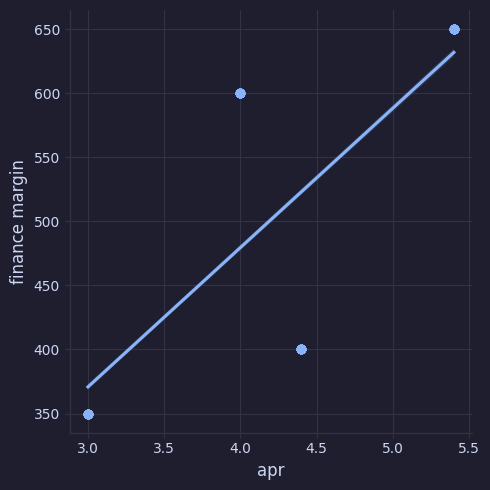

In [43]:
sales_only_df = df.dropna()

sns.lmplot(data=sales_only_df, x="apr", y="finance margin")
slope, intercept, r, p_val, std_err = stats.linregress(sales_only_df['apr'],sales_only_df['finance margin'])
print('finance margin =', slope,'(apr) +', intercept)
print('r:', r)

Roughly speaking, the linear regression above implies that a 1 point increase in APR translates to about a 109 dollar increase in finance margin per sale. Of course, this is not nearly as precise in practice: moving from a 4.00 to a 4.40 point APR yields 200 dollar *decrease* in finance margin per sale.

We can create a similar graph with the FICO on the x-axis and finance margin on the y-axis:

finance margin = -0.5191525576426829 (apr) + 829.2713179791115
r: -0.20241004960174327


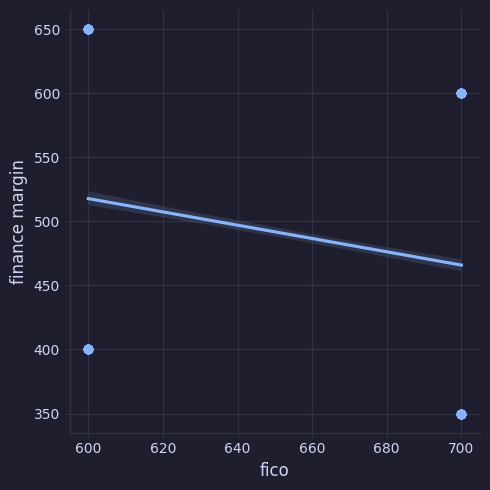

In [44]:
sns.lmplot(data=sales_only_df, x="fico", y="finance margin")
slope, intercept, r, p_val, std_err = stats.linregress(sales_only_df['fico'],sales_only_df['finance margin'])
print('finance margin =', slope,'(apr) +', intercept)
print('r:', r)

This regression is not useful. The correlation coefficient is very weak, and it is clear from the contingency table for finance margins by FICO and APR above that an increase in FICO is not necessarily associated with a decrease in finance margin. It would be inappropriate to extrapolate or interpolate finance margins using FICO.

### 4. Margin Optimization <a class="anchor" id="margin_optimization"></a>

`Using your understanding of conversion and total margin (across all applications) and how APR affects the two, if Acme wants to optimize total margin, do you think Acme should raise or lower rates on 700 FICO customers? What about 600 FICO customers?`

In [45]:
finance_margins_by_apr

finance margin  350.0  400.0  600.0  650.0  total finance  total overall
fico apr                                                                
700  3.00%       1505      0      0      0         526750        2031750
     4.00%          0      0   1300      0         780000        2080000
600  4.40%          0   1172      0      0         468800        1640800
     5.40%          0      0      0   1044         678600        1722600

Acme should use the higher APRs in both FICO categories. While the lower APRs result in a higher number of conversions, this is not enough to offset the decrease in finance margins. Based on this data, the highest margins are achieved by higher APRs in both the 600 and 700 FICO categories.

Below is a table from earlier, which gives the sale conversion rates within each APR category. We have added an additional column `margin factor`. We define $$\texttt{margin factor} = (\text{finance margin} + \text{vehicle margin}) \times \text{conversion rate}.$$ The highest `margin factor` is the leading performer assuming that APR conversion rates are fixed. Note that the `total overall` from the previous table is simply the `margin factor` multiplied by the number of applicants within each category.

In [46]:
finance_margins_by_apr['margin factor'] = finance_margins_by_apr['total overall']/(sale_by_apr['total count'])

In [47]:
sale_by_apr.join(sale_by_apr_relfreqs)
finance_margins_by_apr

False  True  total count  proportion of total sales  \
fico apr                                                          
700  3.00%   3568  1505         5073                   0.299741   
     4.00%   3626  1300         4926                   0.258913   
600  4.40%   3734  1172         4906                   0.233420   
     5.40%   4051  1044         5095                   0.207927   

            apr category conversion rate  
fico apr                                  
700  3.00%                      0.296669  
     4.00%                      0.263906  
600  4.40%                      0.238891  
     5.40%                      0.204907

finance margin  350.0  400.0  600.0  650.0  total finance  total overall  \
fico apr                                                                   
700  3.00%       1505      0      0      0         526750        2031750   
     4.00%          0      0   1300      0         780000        2080000   
600  4.40%          0   1172      0      0         468800        1640800   
     5.40%          0      0      0   1044         678600        1722600   

finance margin  margin factor  
fico apr                       
700  3.00%         400.502661  
     4.00%         422.249289  
600  4.40%         334.447615  
     5.40%         338.096173

### 5. Summary Remarks <a class="anchor" id="summary_remarks"></a>

`Other than these cut and dry numbers, can you think of other factors Acme might want to take into account before changing rates? A few several-sentence bullet points are sufficient.`

The previous paragraph and table show that Acme should pursue higher APR rates within their respective FICO categories. However, it is clear that the 3.00% and 4.00% APR rates outperform the 4.40% and 5.40% APR rates in terms of total overall margin despite the 4.40% and 5.40% rates maintaining higher per-sale margins than their 700 FICO counterparts.

It may be worth investigating whether 3.00% and 4.00% APRs should be offered to the 600 FICOs. Given the vehicle margin and the APR rate finance margins, one might consider pursuing sale conversion as a leading metric. For example, 3% APRs have the lowest finance margin, but the high conversion frequency takes it to near first place in total overall margin. On the other hand, a lower FICO comes with increased risk.

Moreover, this strategy carries the assumption that conversion rates are constant. It could be the case that conversion rates are variable over time, even within their respective categories.

In [48]:
sale_by_apr
type(sale_by_apr['total count'].iloc[0])

converted to sale  False  True  total count
fico apr                                   
700  3.00%          3568  1505         5073
     4.00%          3626  1300         4926
600  4.40%          3734  1172         4906
     5.40%          4051  1044         5095

numpy.int64